In [1]:
# DO NOT MODIFY! helper functions and constants
import nbimporter
from p1 import cv2, np, plt, math, os
from p1 import get_parameters, Gauss2D, filter_image_vec

image_list, constants = get_parameters()

#----------------------------------------------------------------------
def visualize(function, image_name, sigma):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)

    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = function(image, sigma)
    
    print("-" * 50 + "\n" + "Original Image:")
    plt.imshow(image_rgb); plt.show() # Displaying the sample image
    
    print("-" * 50 + "\n" + "Edge Magnitude:")
    plt.imshow(image_m, cmap="gray"); plt.show()
    
    print("-" * 50 + "\n" + "Edge Orientation:")
    plt.imshow(image_o, cmap="gray"); plt.show()
    
    print("-" * 50 + "\n" + "Gradient x:")
    plt.imshow(image_x, cmap="gray"); plt.show()
    
    print("-" * 50 + "\n" + "Gradient y:")
    plt.imshow(image_y, cmap="gray"); plt.show()
    
    return

### Q2.1 Edge Detection (10 points)

Write a function that computes the edge intensity magnitude, edge orientation and image gradients of the image.  

```
  def edge_detection(image, sigma):
    
        return image_m, image_o, image_x, image_y

```

- **Input**: a grayscale image *$image$* and a scalar *$sigma$* representing the std dev of Gaussian kernel. 
- **Output**: *$image\_m$* is the edge magnitude image, *$image\_o$* is the edge orientation image, *$image\_x$* and *$image\_y$* are image gradients in x and y directions respectively. 

**Instructions**
- Your code cannot call pre-existing edge functions from python libraries.
- Use *filter_image_vec* function in your implementation. 
- Smooth the *$image$* using a Gaussian kernel defined by *$sigma$*. This will reduce noise and spurious fine edges in the image.
- Use the Sobel filters to find the image gradients *$image\_x$* and *$image\_y$* by convolving it with the smoothed image.
- Refer Lecture Slides on Image Gradients and Gradient Filtering. Note, *$image\_x$* measures horizontal change in intensity so will respond to vertical lines in the image and vice-versa. https://theailearner.com/2019/05/11/understanding-image-gradients/
- *$image\_m$* and *$image\_o$* can be calculated from *$image\_x$* and *$image\_y$*.
- *$image\_m$* is in [-$\rho_{\text{max}}$, $\rho_{\text{max}}$].
- *$image\_o$* is in degrees, $[0, 360^\circ]$.

**Grading**
- Your code will be autograded with 10 images. 
- The outputs of the function will be compared with the outputs of a reference implementation with an error threshold of 1e-5.

In [2]:
def edge_detection(image, sigma):
    """Detect edges in the image

    Args:
        image: np.array, HxW, the input grayscale image. 
        sigma: float, std dev of the Gauss2D filter used as in creation of h_filter. 

    Returns:
        image_m: np.array, HxW, contains the edge magnitudes, each value in [-rho_max ,rho_max]
        image_o: np.array, HxW, edge orientations in degrees [0, 360]
        image_x: np.array, HxW, image gradient in x
        image_y: np.array, HxW, image gradient in y
    """
    h_size = 2*math.ceil(3*sigma) + 1
    gaussian_kernel = Gauss2D(kernel=(h_size, h_size), sigma=sigma)
    
    #--------------------------------------
    # smooth image using gaussian kernel, we overwrite variable image with the smoothed image!
    image_s = filter_image_vec(image, gaussian_kernel)
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    #--------------------------------------
    # define sobel_filter_x and sobel_filter_y, you can ignore the 1/8 normalization weight!
    sobel_filter_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    image_x = filter_image_vec(image_s, sobel_filter_x)
    image_y = filter_image_vec(image_s, sobel_filter_y)
    
    image_m = np.sqrt(np.multiply(image_x, image_x) + np.multiply(image_y, image_y))
    #image_m = (image_m_t*255)/np.amax(image_m_t)
    image_o = (((np.arctan(image_y, image_x)) * 180) / np.pi) % 360

    #raise NotImplementedError()
    
    return image_m, image_o, image_x, image_y

### Test Q2.1

--------------------------------------------------
Original Image:


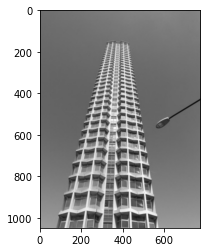

--------------------------------------------------
Edge Magnitude:


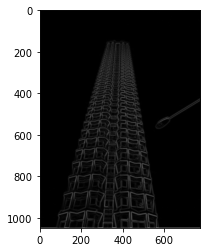

--------------------------------------------------
Edge Orientation:


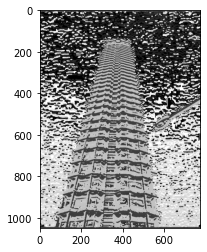

--------------------------------------------------
Gradient x:


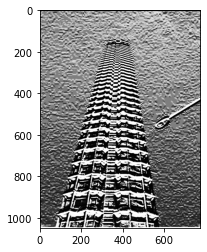

--------------------------------------------------
Gradient y:


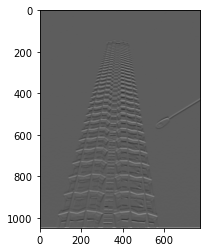

In [3]:
image_idx = np.random.randint(0, len(image_list))
visualize(edge_detection, image_list[image_idx], constants.sigma)

### Q2.2 Edge Detection with Non-Maximal Suppression (15 points)
Write a function along with two helper functions which performs Non-Maximal Suppression (NMS) to modify *$image\_m$* using *$image\_m$* and *$image\_o$*. 

```
    def edge_detection_nms(image, sigma):
        return image_m, image_o, image_x, image_y
        
    def edge_nms(image_m, image_o):
        return image_m_prime
    
    def keep_pixel(image_m, i, j, gradient)::
        return output
```

**Instructions**
- Many times the high gradient magnitude region along an edge will be quite thick.
- This will lead to infering thick edges as multiple thin edges.
- We wish to avoid this as for finding lines in the image, it is best to have edges that are a single pixel wide.
- We will be using nested loops for simplicity, but feel free to use vectorization for efficiency.

**NMS Algorithm**: 
* For each pixel, look at the two neighboring pixels along the gradient direction
* If either of those pixels has a larger gradient magnitude then set the edge magnitude in *$image\_m$* at the center pixel to zero. 
* Map the gradient angle in *$image\_o$* to the closest of 4 cases, where the line is sloped at almost [0$^\circ$, 45$^\circ$, 90$^\circ$, 135$^\circ$] 
* Note, the other 4 cases [180$^\circ$, 225$^\circ$, 270$^\circ$, 315$^\circ$, 360$^\circ$] are already captured because of the symmetry of the suppression condition. 
* Eg, 20$^\circ$ would map to 0$^\circ$ and 30$^\circ$ would map to 45$^\circ$.


More details on non-maximum suppression (again we use 4 cases instead of 8 cases!). 

<img align="center" src="data/handout/q2.png" width="700">

**Grading**
Same as Q2.1

In [ ]:
def edge_detection_nms(image, sigma):
    """Detect edges in the image with nms preprocessing

    Args:
        image: np.array, HxW, the input grayscale image. 
        sigma: float, std dev of the Gauss2D filter used as in creation of h_filter. 

    Returns:
        image_m: np.array, HxW, contains the edge magnitudes
        image_o: np.array, HxW, edge orientations in degrees [0, 360]
        image_x: np.array, HxW, image gradient in x
        image_y: np.array, HxW, image gradient in y
    """
    h_size = 2*math.ceil(3*sigma) + 1
    gaussian_kernel = Gauss2D(kernel=(h_size, h_size), sigma=sigma)
    
    #--------------------------------------
    # smooth image using gaussian kernel, we overwrite variable image with the smoothed image!
    # image = ?
    # YOUR CODE HERE
    raise NotImplementedError()
    
    #--------------------------------------
    # define sobel_filter_x and sobel_filter_y, you can ignore the 1/8 normalization weight!
    # sobel_filter_x = ?
    # sobel_filter_y = ?
    # YOUR CODE HERE
    raise NotImplementedError()
    
    image_x = filter_image_vec(image, sobel_filter_x)
    image_y = filter_image_vec(image, sobel_filter_y)
    
    # image_m = ?
    # image_o = ?
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # apply nms
    image_m = edge_nms(image_m, image_o)
    
    return image_m, image_o, image_x, image_y

#----------------------------------------------------------------------
def edge_nms(image_m, image_o):
    """Performs edge nms on image_m
    Args:
        image_m: np.array, HxW, edge magnitude image
        image_o: np.array, HxW, edge orientations image

    Returns:
        image_m_prime: np.array, suppressed image_m after NMS
    """
    mask = np.ones_like(image_m) ## per pixel boolean mask, 1 = keep, 0 = suppress
    
    # loop per pixel
    for i in range(1, image_m.shape[0]-1):
        for j in range(1, image_m.shape[1]-1):
            
            # round of the pixel gradient to one of the 4 cases in degrees. Reminder, image_o is [0, 360]
            # pixel_gradient = ?
            # YOUR CODE HERE
            raise NotImplementedError()
            
            mask[i, j] = keep_pixel(image_m, i, j, pixel_gradient)
    
    image_m_prime = mask*image_m
    
    return image_m_prime

#----------------------------------------------------------------------
def keep_pixel(image_m, i, j, gradient):
    """Performs edge nms on image_m
    Args:
        image_m: np.array, HxW, edge magnitude image 
        i: integer, row index of pixel
        j: integer, col index of pixel
        gradient: integer, rounded gradient in degrees, one of the values in [0, 45, 90, 135].

    Returns:
        output: boolean integer (1 or 0). 1 to keep pixel, 0 to suppress pixel
    """
    
    # Compare the magnitude at image_m[i, j] with its neighbours
    # angle decides which neighbours to check
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return output


### Test Q2.2

In [ ]:
image_idx = np.random.randint(0, len(image_list))
visualize(edge_detection_nms, image_list[image_idx], constants.sigma)

### Autograde Q2.1
1 points per test case, 10 test cases.

### Autograde Q2.2
1.5 points per test case, 10 test cases.